In [1]:
import numpy as np
import cv2
from PIL import Image

# Optional: decimal module if you want high-precision arithmetic for chaos
from decimal import Decimal, getcontext
use_decimal = False  # Toggle to True if you want to use high-precision decimals
if use_decimal:
    getcontext().prec = 50  # Example: 50 decimal digits

def load_image(image_path, mode='color'):
    """
    Loads an image from disk into a NumPy array.
      - mode='color': returns shape (H, W, 3)
      - mode='gray': returns shape (H, W)
    Returns both the NumPy array and the PIL image object.
    """
    if mode == 'gray':
        pil_img = Image.open(image_path).convert('L')
        img_array = np.array(pil_img)
    else:
        pil_img = Image.open(image_path).convert('RGB')
        img_array = np.array(pil_img)
    return img_array, pil_img

def normalize_image(img_array):
    """
    Converts the pixel values [0..255] to floating-point [0..1].
    If using high precision (Decimal), convert to Decimal as well.
    """
    if use_decimal:
        # Convert each pixel to Decimal( pixel_value / 255.0 )
        return np.vectorize(lambda x: Decimal(x)/Decimal(255))(img_array)
    else:
        return img_array.astype(np.float64) / 255.0

def denormalize_image(norm_array):
    """
    Converts a normalized array [0..1] (float or Decimal) back to [0..255] as uint8.
    """
    if use_decimal:
        # Multiply by 255, convert to int
        return np.vectorize(lambda x: int((x*Decimal(255)).to_integral_value()))(norm_array)
    else:
        return np.rint(norm_array * 255).astype(np.uint8)


In [2]:
# Example usage in a Jupyter cell or script
img_array, pil_img = load_image("input.png", mode='color')
norm_array = normalize_image(img_array)  # optional if needed for chaotic maps


In [3]:
import random
import math

# ================== ARNOLD'S CAT MAP ==================
def arnold_cat_transform(img_array):
    """
    One iteration of Arnold's Cat Map:
        (x', y') = (x + y) mod n, (x + 2y) mod n
    Expects a square image: shape (n, n, 3) or (n, n)
    """
    n = img_array.shape[0]
    transformed = np.zeros_like(img_array)
    for x in range(n):
        for y in range(n):
            new_x = (x + y) % n
            new_y = (x + 2*y) % n
            transformed[new_x, new_y] = img_array[x, y]
    return transformed

def arnold_cat_encrypt(img_array, iterations):
    """
    Encrypt by applying Arnold’s Cat transform 'iterations' times.
    Returns the encrypted NumPy array.
    Note: For saving, you'll do that in the Output Layer.
    """
    h, w = img_array.shape[:2]
    if h != w:
        raise ValueError("Arnold’s Cat requires a square image!")
    encrypted = img_array.copy()
    for _ in range(iterations):
        encrypted = arnold_cat_transform(encrypted)
    return encrypted


# ================== HENON MAP ==================
def henon_map_sequence(num_bits, x0=0.1, y0=0.1, a=1.4, b=0.3):
    """
    Generates 'num_bits' bits using the Henon map. 
    """
    if use_decimal:
        x = Decimal(x0)
        y = Decimal(y0)
        a_ = Decimal(a)
        b_ = Decimal(b)
    else:
        x = float(x0)
        y = float(y0)
        a_ = float(a)
        b_ = float(b)

    bits = []
    for _ in range(num_bits):
        x_next = y + 1 - a_ * (x**2)
        y_next = b_ * x
        x, y = x_next, y_next
        bit = 0 if x <= 0.4 else 1
        bits.append(bit)
    return bits

def bits_to_bytes(bits):
    """
    Converts a list of bits (0/1) into a list of 8-bit integers [0..255].
    """
    assert len(bits) % 8 == 0
    out = []
    for i in range(0, len(bits), 8):
        val = 0
        for b in bits[i:i+8]:
            val = (val << 1) | b
        out.append(val)
    return out

def henon_encrypt(img_array, x0=0.1, y0=0.1):
    """
    XOR-based encryption with Henon map. 
    """
    shape = img_array.shape
    if len(shape) == 2:
        h, w = shape
        c = 1
    else:
        h, w, c = shape

    total_pixels = h * w
    needed_bytes = total_pixels * c
    needed_bits = needed_bytes * 8

    # Generate chaotic bits
    henon_bits = henon_map_sequence(needed_bits, x0, y0)
    # Convert to bytes
    henon_stream = bits_to_bytes(henon_bits)

    # XOR each pixel
    encrypted = np.zeros_like(img_array)
    idx = 0
    for row in range(h):
        for col in range(w):
            if c == 1:
                # Grayscale
                px = img_array[row, col]
                enc_val = px ^ henon_stream[idx]
                encrypted[row, col] = enc_val
                idx += 1
            else:
                # Color
                px = img_array[row, col]
                r_enc = px[0] ^ henon_stream[idx]
                g_enc = px[1] ^ henon_stream[idx+1]
                b_enc = px[2] ^ henon_stream[idx+2]
                encrypted[row, col] = [r_enc, g_enc, b_enc]
                idx += 3
    return encrypted


# ================== LOGISTIC MAP ==================
def logistic_map_sequence(num_values, r=3.99, seed=0.2):
    """
    Generate 'num_values' pseudorandom bytes [0..255] from a logistic map:
       x_{n+1} = r * x_n * (1 - x_n)
    """
    if use_decimal:
        x = Decimal(seed)
        r_ = Decimal(r)
    else:
        x = float(seed)
        r_ = float(r)

    out_bytes = []
    for _ in range(num_values):
        x = r_ * x * (1 - x)
        b = int((x * 1e6) % 256)  # e.g., multiply by 1e6, mod 256
        out_bytes.append(b)
    return out_bytes

def logistic_encrypt(img_array, key_string="mysecretkey_____"):
    """
    XOR-based encryption using a logistic map. 
    The 'key_string' can be used to vary 'r' or 'seed' in more advanced ways.
    For simplicity, we just do a fixed r=3.99, seed=0.2 here.
    """
    shape = img_array.shape
    if len(shape) == 2:
        h, w = shape
        c = 1
    else:
        h, w, c = shape

    total_pixels = h * w
    needed_bytes = total_pixels * c

    # Simple example: produce needed_bytes from logistic map
    chaos_stream = logistic_map_sequence(needed_bytes, r=3.99, seed=0.12345)

    encrypted = np.zeros_like(img_array)
    idx = 0
    for row in range(h):
        for col in range(w):
            if c == 1:
                px = img_array[row, col]
                enc_val = px ^ chaos_stream[idx]
                encrypted[row, col] = enc_val
                idx += 1
            else:
                px = img_array[row, col]
                encrypted[row, col, 0] = px[0] ^ chaos_stream[idx]
                encrypted[row, col, 1] = px[1] ^ chaos_stream[idx+1]
                encrypted[row, col, 2] = px[2] ^ chaos_stream[idx+2]
                idx += 3
    return encrypted


In [4]:
import matplotlib.pyplot as plt

def compute_histogram(img_array):
    """
    Displays a histogram for grayscale or color images.
    """
    if len(img_array.shape) == 2:
        # Grayscale
        plt.hist(img_array.ravel(), bins=256, range=(0,255), color='gray')
        plt.title("Grayscale Histogram")
        plt.show()
    else:
        # Color
        colors = ('b', 'g', 'r')
        for i, c in enumerate(colors):
            hist = cv2.calcHist([img_array.astype('uint8')], [i], None, [256], [0,256])
            plt.plot(hist, color=c)
        plt.title("Color Histogram")
        plt.show()

def adjacent_pixel_correlation(img_array, sample_size=1024):
    """
    Plot correlation of horizontally adjacent pixels for 'sample_size' points.
    """
    h, w = img_array.shape[:2]
    # convert color to gray if needed
    if len(img_array.shape) == 3:
        img_gray = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_array

    samples_x = []
    samples_y = []
    import random
    for _ in range(sample_size):
        row = random.randint(0, h-1)
        col = random.randint(0, w-2)
        px1 = img_gray[row, col]
        px2 = img_gray[row, col+1]
        samples_x.append(px1)
        samples_y.append(px2)
    plt.scatter(samples_x, samples_y, s=2)
    plt.title("Adjacent Pixel Correlation")
    plt.xlabel("Pixel (row, col)")
    plt.ylabel("Pixel (row, col+1)")
    plt.show()

def key_sensitivity_test(encryption_func, img_array, correct_key, wrong_key):
    """
    Demonstrate how a small change in key breaks decryption. 
    Only relevant if the encryption_func is XOR-based with a separate decrypt step.
    """
    print("Encrypting with correct key:", correct_key)
    encrypted_correct = encryption_func(img_array, correct_key)

    print("Encrypting with wrong key:", wrong_key)
    encrypted_wrong = encryption_func(img_array, wrong_key)

    # Usually you'd also show how each encryption would be decrypted 
    # to prove that the correct key decrypts properly, while the wrong key fails.
    return encrypted_correct, encrypted_wrong


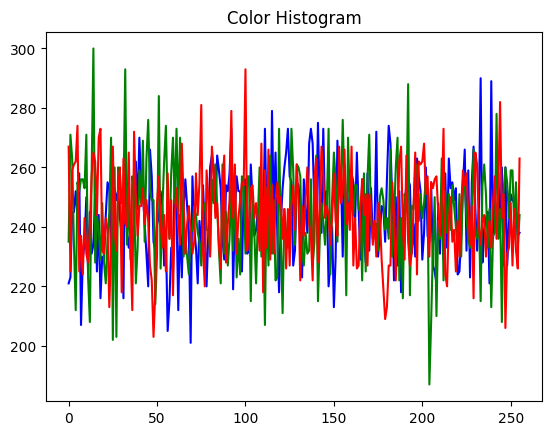

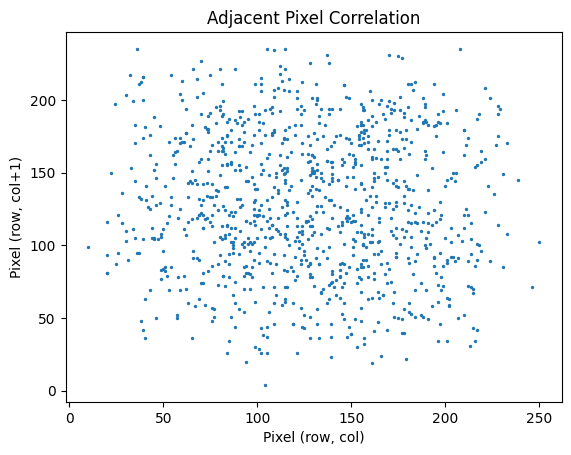

In [5]:
enc_img = logistic_encrypt(img_array, "mycorrectkey123")
compute_histogram(enc_img)
adjacent_pixel_correlation(enc_img)


In [6]:
# ARNOLD'S CAT DECRYPT
def arnold_cat_period(n):
    """
    Heuristic to estimate the period at which Arnold's Cat returns to original 
    for a dimension 'n'.
    """
    if (n % 2 == 0) and 5**int(round(math.log(n/2,5))) == int(n/2):
        return 3*n
    elif 5**int(round(math.log(n,5))) == int(n):
        return 2*n
    elif (n % 6 == 0) and 5**int(round(math.log(n/6,5))) == int(n/6):
        return 2*n
    else:
        return int(12*n/7)

def arnold_cat_decrypt(enc_array, iterations):
    """
    Decrypt by continuing the Arnold transform from 'iterations' up to 'period'.
    """
    h, w = enc_array.shape[:2]
    if h != w:
        raise ValueError("Arnold’s Cat requires a square image!")

    period = arnold_cat_period(h)
    dec = enc_array.copy()
    for i in range(iterations, period):
        dec = arnold_cat_transform(dec)
    return dec

# HENON DECRYPT
def henon_decrypt(enc_array, x0=0.1, y0=0.1):
    """
    XOR-based: Decryption = Encryption with same key. 
    So we just call henon_encrypt again.
    """
    return henon_encrypt(enc_array, x0, y0)  # same function

# LOGISTIC DECRYPT
def logistic_decrypt(enc_array, key_string="mysecretkey_____"):
    """
    XOR-based: Decryption = Encryption with same key/seed.
    """
    return logistic_encrypt(enc_array, key_string)


In [7]:
# For Henon / Logistic (XOR-based):
dec_img = logistic_decrypt(enc_img, "mycorrectkey123")

# For Arnold’s Cat:
dec_arnold = arnold_cat_decrypt(enc_arnold, iterations=10)


NameError: name 'enc_arnold' is not defined